kaggle 데이터를 사용하여 만든 이진 분류 모델

## 0. Import Library

In [2]:
!pip install tqdm
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import os 
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import tensorflow as tf

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data

In [4]:
# 경로 설정
data_dir = "../kaggle/"

# 이미지 리스트 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# 카테고리 리스트 및 경로 초기화
path_list = ["Mild Dementia", "Moderate Dementia", 
             "Non Demented", "Very mild Dementia"]

In [5]:
# 카테고리 별 이미지 경로 저장을 위한 딕셔너리 초기화
image_paths = {
    "Mild Dementia": [],
    "Moderate Dementia": [],
    "Non Demented": [],
    "Very mild Dementia": []
}

# 각 카테고리 별 경로 추가
for category in path_list:
    category_dir = os.path.join(data_dir, category)
    for dirname, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_paths[category].append(os.path.join(dirname, filename))

# 확인
for category in path_list:
    print(f'{category}: {len(image_paths[category])} images')

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images


In [6]:
# 각 카테고리별 파일 경로 리스트
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

images, labels = [], []

In [7]:
# 각 카테고리 폴더 내 파일 경로를 리스트에 추가
for category in tqdm(path_list):
    category_dir = os.path.join(data_dir, category)
    for root, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_path = os.path.join(root, filename)
            images.append(image_path)
            labels.append(category)
            if category == "Non Demented":
                non_demented.append(image_path)
            elif category == "Very mild Dementia":
                very_mild_demented.append(image_path)
            elif category == "Mild Dementia":
                mild_demented.append(image_path)
            elif category == "Moderate Dementia":
                moderate_demented.append(image_path)

100%|██████████| 4/4 [00:00<00:00, 27.77it/s]


In [8]:
# 이미지 경로와 레이블을 포함하는 DataFrame 생성
df = pd.DataFrame({'image': images, 'label': labels})
df.head() 

,image,label
0,../kaggle/Mild Dementia/OAS1_0137_MR1_mpr-3_13...,Mild Dementia
1,../kaggle/Mild Dementia/OAS1_0291_MR1_mpr-3_10...,Mild Dementia
2,../kaggle/Mild Dementia/OAS1_0278_MR1_mpr-2_11...,Mild Dementia
3,../kaggle/Mild Dementia/OAS1_0382_MR1_mpr-4_12...,Mild Dementia
4,../kaggle/Mild Dementia/OAS1_0316_MR1_mpr-1_14...,Mild Dementia


/var/folders/s1/nf_zq41n2nd447kv5d44gx2h0000gn/T/ipykernel_48083/1748014159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


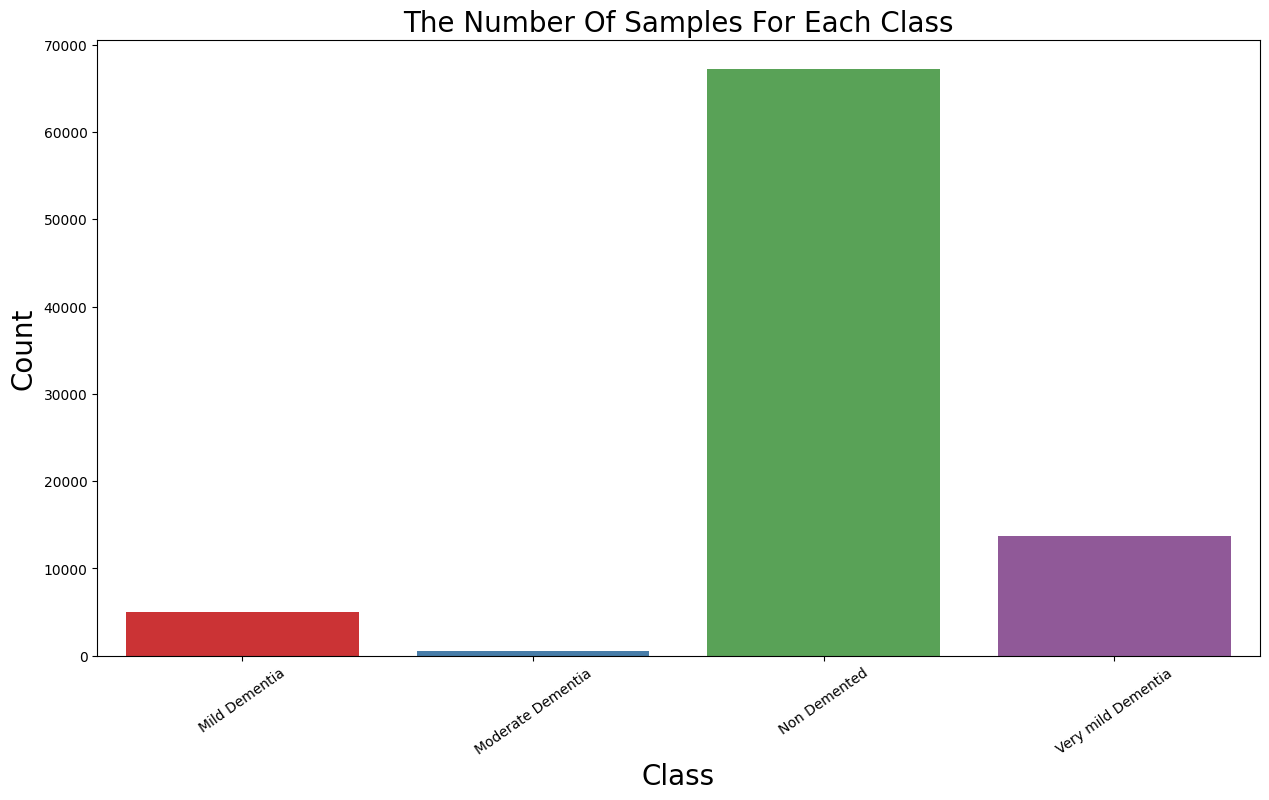

In [9]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

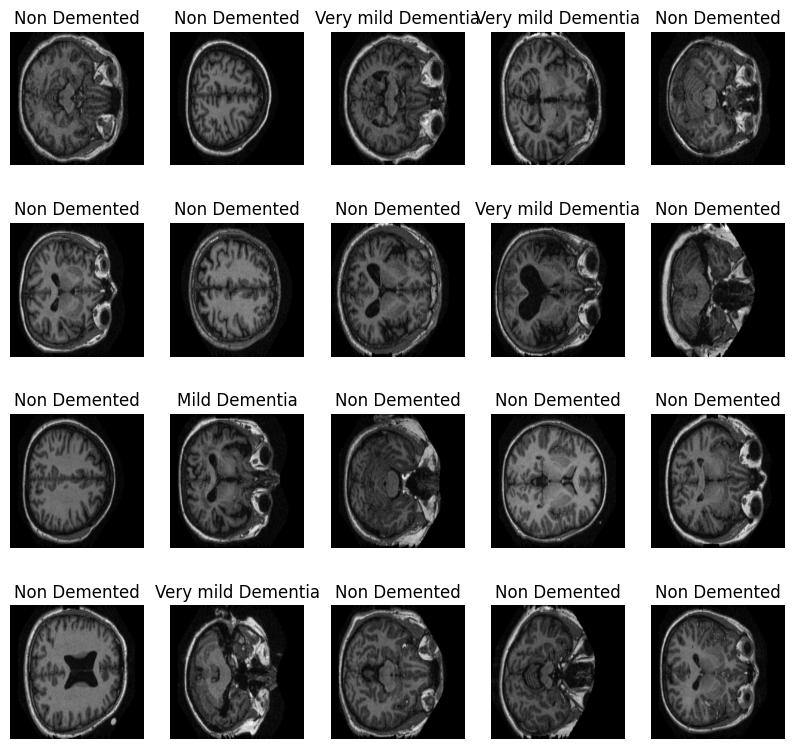

In [10]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

## 2. Preprocessing

In [11]:
data = []
result = []

### 1) Label Encoding

In [12]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [13]:
# 각 리스트에서 이미지를 읽어와 데이터와 결과에 추가하는 함수
def load_images(category_list, label):
    for image_path in category_list:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        data.append(img)
        result.append(encoder.transform([[label]]).toarray())

In [14]:
# 각 카테고리별로 이미지 로드
load_images(non_demented, 0)
load_images(very_mild_demented, 1)
load_images(mild_demented, 2)
load_images(moderate_demented, 3)

In [15]:
# 결과 데이터 변환 확인
data = np.array(data)
result = np.array(result).reshape(len(result), -1)
print(f"Data shape: {data.shape}, Result shape: {result.shape}")

Data shape: (86437, 128, 128, 3), Result shape: (86437, 4)


### 2) Reshape data

In [16]:
X=np.array(data)
y=np.array(result)

y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

### 3) Balance data

In [17]:
# 라벨을 2개의 그룹으로 변경
y = np.where(y <= 1, 0, 1)

indices_0 = np.where(y == 0)[0]
indices_1 = np.where(y == 1)[0]

# 두 그룹 중 최소 수를 구하기
min_count = min(len(indices_0), len(indices_1))

# 각 그룹에서 최소 수만큼 샘플링
balanced_indices_0 = np.random.choice(indices_0, min_count, replace=False)
balanced_indices_1 = np.random.choice(indices_1, min_count, replace=False)
balanced_indices = np.concatenate([balanced_indices_0, balanced_indices_1])

X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

### 3) Split data

In [18]:
X_train, X_test, y_train, y_test= train_test_split(X_balanced, y_balanced,test_size=0.2,random_state=42, shuffle = True)
print("X train shape: ", X_train.shape)
print("Ytrain shape: ", y_train.shape)

X train shape:  (8784, 128, 128, 3)
Ytrain shape:  (8784,)


## 3. Modeling

In [45]:
# CNN 모델 생성
def create_compile_model():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2,activation='sigmoid')) # 이진 모델이므로 수정

    print(model.summary())

    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [46]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

checkpoint = ModelCheckpoint(
    filepath='../model/binary_model.keras',  
    monitor='val_loss',       
    save_best_only=True,       
    mode='min',               
    verbose=1               
)

## 4. Training

In [47]:
model = create_compile_model()

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,082 (32.49 MB)

 Trainable params: 8,517,634 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [48]:
history= model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs=15,
                   callbacks=[early_stopping, checkpoint],
                    batch_size=32)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7240 - loss: 2.2723
Epoch 1: val_loss improved from inf to 0.44672, saving model to ../model/binary_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 384ms/step - accuracy: 0.7244 - loss: 2.2662 - val_accuracy: 0.7439 - val_loss: 0.4467
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9087 - loss: 0.2239
Epoch 2: val_loss improved from 0.44672 to 0.12489, saving model to ../model/binary_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 363ms/step - accuracy: 0.9088 - loss: 0.2238 - val_accuracy: 0.9522 - val_loss: 0.1249
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9516 - loss: 0.1227
Epoch 3: val_loss improved from 0.12489 to 0.08181, saving model to ../model/binary_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 371ms/step - accuracy: 0.9516 - loss: 0.1227 - val_accuracy: 0.9744 - val_loss: 0.0818
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9679 - loss: 0.0880
Epoc

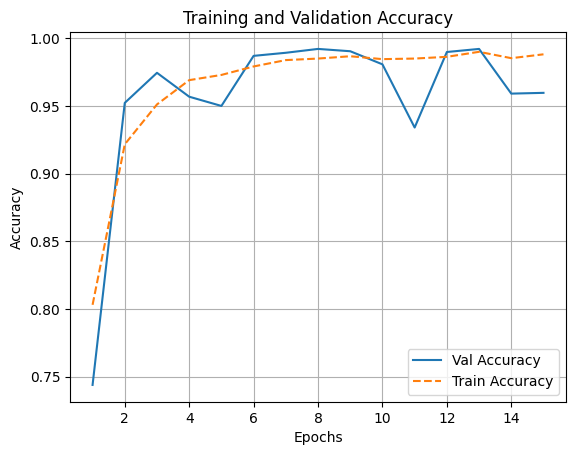

In [49]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy,  label=f'Val Accuracy')
plt.plot(epochs, train_accuracy, linestyle='--', label=f'Train Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### 데이터 정확도 확인

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step


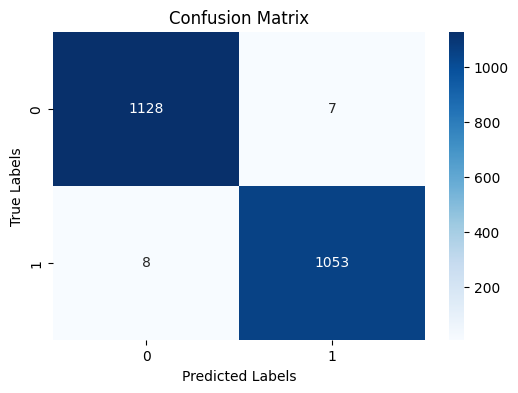

In [50]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### GradCAM 확인

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Grad model 생성 (모델 입력과 마지막 conv 레이어 및 모델 출력을 연결)
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # 가장 높은 확률을 가진 클래스 인덱스
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # 각 채널의 평균 그라디언트
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # 가중합을 통해 heatmap 생성
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # ReLU와 정규화
    return heatmap

# 이미지 불러오기 및 전처리
def preprocess_image(img_path, target_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # 정규화
    return img

# 학습 데이터 중 하나를 선택
img = X_test[0]  # x_test에서 첫 번째 이미지를 선택 
img_array = np.expand_dims(img, axis=0)  # 배치 차원 추가

# Grad-CAM 적용 전에 예측 수행
_ = model.predict(img_array)  # img_array를 통해 예측 수행

# Grad-CAM 적용
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_17')

# 원본 이미지에 Heatmap 적용
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

# 이미지 출력
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


AttributeError: The layer sequential_2 has never been called and thus has no defined input.

In [55]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,553,352 (97.48 MB)

 Trainable params: 8,517,634 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 17,035,270 (64.98 MB)